# SIRD parameter learning using GD with Tikhonov regularisation

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^2} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2 + \frac{\theta}{2} \|\alpha\|^2,
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state. The regularisation parameter $\theta$ is non negative. We will study the effect of this parameter on the choice of the control pair $\alpha$.
    
For each pair of parameters $\alpha = (\beta, \gamma) \in [0,1]^2$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - (\gamma+m) I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, ones, allclose, arctan, exp, pi, append, arange
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from scipy.interpolate import CubicHermiteSpline
from numpy.polynomial.chebyshev import chebpts1
from matplotlib.cm   import get_cmap

# Problem setup

Initial conditions:

In [4]:
# Total population
n = 200
# Initial conditions
f = 5e-2
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0    # These are for reference, changing them won't affect the later code
# Deceased rate
m = 0.01

## Generation of $\widehat \rho$

We are going to generate one choice for $\widehat\rho$ as the three curves that satisfy the initial conditions.

In [5]:
T  = 10                            # Final time
Tₑ = 0.5*(chebpts1(200)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])     # Add endpoints

In [6]:
# Parameters for the shape of R and S
aᵣ = 2.0;    bᵣ = 3;    cᵣ = 0.6
aₛ = 6;       bₛ = 0.001;    cₛ = 0.5

Rₜ  = 2 * arctan(aᵣ * (Tₑ - bᵣ)) / pi              # Weighted arctan
Rₜ  = (Rₜ - Rₜ[0])/(1 - Rₜ[0])                       # Normalised curve in [0, 1]
Rₜ *= cᵣ * n                                       # Limit recovered to cᵣ * n

Sₜ  = (exp(-bₛ * Tₑ**aₛ) + (1-cₛ))/(2.0 - cₛ)        # Normalised super gaussian in [cₛ/(2-cₛ),1]
Sₜ *= n * (1 - f)                                  # Proportion of susceptible at time 0: Sₒ 

In [7]:
Iₜ = n - Sₜ - Rₜ                                    # Infected is difference
if Iₜ.min() < 0:
    maximum(Iₜ, Iₜ[Iₜ > 0.0].min(), Iₜ);             # Ensure non negativity (might result in Sₜ + Iₜ + Rₜ > n)

In [8]:
print('Sₜ + Iₜ + Rₜ = n holds?', allclose(Sₜ + Iₜ + Rₜ, n))

Sₜ + Iₜ + Rₜ = n holds? True


Compute first derivative in time of desired state, just for interpolator:

In [9]:
dRₜ  = (2 * aᵣ) / ( pi * ( aᵣ**2 * (Tₑ - bᵣ)**2 + 1 ) )    # Weighted arctan
dRₜ /= 1 - Rₜ[0]                                            # Normalised curve in [0, 1]
dRₜ *= cᵣ * n                                              # Limit recovered to cᵣ * n

dSₜ  = -( aₛ * bₛ * (Tₑ)**(aₛ - 1.0) * exp(-bₛ * Tₑ**aₛ) )/(2.0 - cₛ)   # Normalised super gaussian in [cₛ/(2-cₛ),1]
dSₜ *= n * (1 - f)                                         # Proportion of susceptible at time 0: Sₒ 

In [10]:
dIₜ = 0.0 - dSₜ - dRₜ                                       # Infected is difference
if ((n - Sₜ - Rₜ) < 0).any():
    dIₜ[n - Sₜ - Rₜ <= 0.0] = 0.0                           # Use a subgradient (might require continuity argument)

Assemble state:

In [11]:
ρ̂  = asarray([Sₜ, Iₜ, Rₜ])
dρ̂ = asarray([dSₜ, dIₜ, dRₜ])

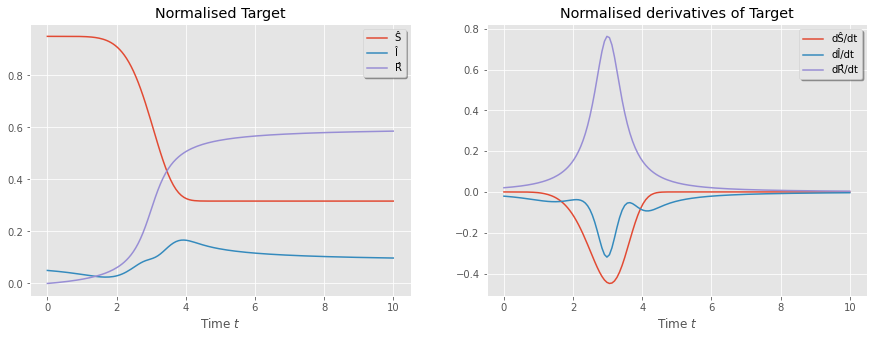

In [12]:
# Plot Target curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['Ŝ', 'Î', 'R̂'], shadow=True)
plt.title('Normalised Target')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, dρ̂.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dŜ/dt', 'dÎ/dt', 'dR̂/dt'], shadow=True)
plt.title('Normalised derivatives of Target')
plt.show()

In [13]:
# Give a random initial control
α = asarray([0.01,0.02])

In [14]:
def SIR(t, z, β,γ):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [15]:
# Compute state ρ(α)
ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                  dense_output=True, vectorized=True)
if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
ρ = ρ_sol.y

# Create an abstract interpolator for state
ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
ρ̄ = CubicHermiteSpline(Tₑ, ρ̂, dρ̂, axis=-1)

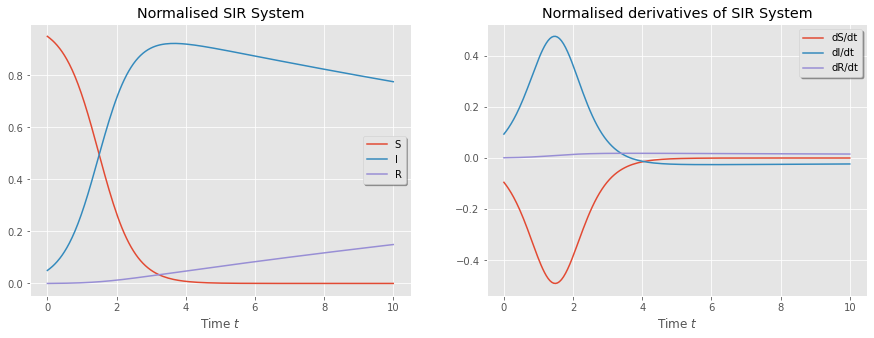

In [16]:
# Plot SIR curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, α[0], α[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = 0$.

Let us see how we can implement this with an adaptive step method:

In [17]:
def Adjoint(t, z, β,γ,ρ):
    S̄, Ī, R̄ = ρ̄(t)    # Target
    S, I, R = ρ(t)    # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}$:

In [18]:
solₛ = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(0.1, 0.01,ρₜ), t_eval = Tₑ[::-1], dense_output=True, vectorized=True)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 416 function evaluations.


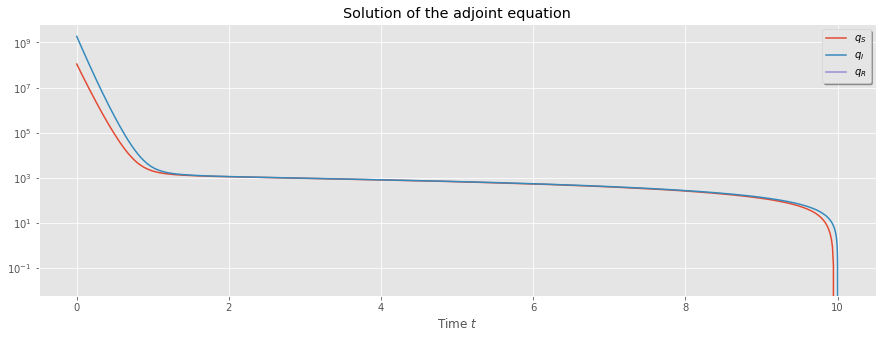

In [19]:
# Plot adjoint curves
plt.figure(figsize=(15,5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
plt.yscale('log')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t + \frac{\theta}{2} ( \beta^2 + \gamma^2 ).
\end{align}

In [20]:
θ = 0.1
def Objective(ρ,ρ̂,α, θ):    return 0.5 * (simpson((ρ-ρ̂)**2,Tₑ).sum() + θ * (α**2).sum())

In [21]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [22]:
print('As an example, the distance between ρ and ρ̂ is {0:.4f}.'.format( Objective(ρ,ρ̂,α,1e+20) ))

As an example, the distance between ρ and ρ̂ is 25000000000152464.0000.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &= \int\limits_0^T S I( q_I - q_S ) \, \dif t + \theta \beta
    \\
    \frac{\partial f}{\partial \gamma} &= \int\limits_0^T I( q_R - q_I ) \, \dif t  + \theta \gamma
\end{align}

In [23]:
q = solₛ.y[:,::-1]

In [24]:
df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ) + θ * α[0], simpson(ρ[1] * (q[2]-q[1]), Tₑ) + θ * α[1]])
display(df.tolist())

[207386783321.35318, -1181698193.521111]

# Surfaces

We can observe what happens with the cost functional for different values of the hyperparameter $\alpha$:

In [25]:
θ = 0.0

In [26]:
def obj_eval_a(α):                # ** Eval just f ** #
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', α)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂,α,θ)
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)

In [27]:
# Coarse evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.00,1,nβ)
γ_axis = linspace(0.02,1,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a( asarray([β,γ]) ).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [28]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 1.8269310740815836; (β,γ): 0.02 0.314


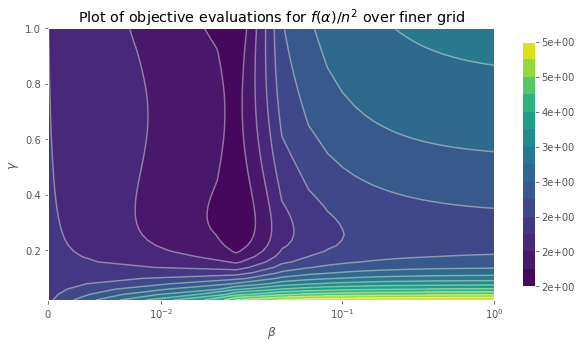

In [29]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.xscale('symlog', linthresh = 1.5e-2)
#plt.xscale('log')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

# Solving the optimisation problem

### Misfit with $\widehat{\rho}$

We will use a gradient-based algorithm for optimising $f$.

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Projected Gradient Descent Algorithm</h2>
<ol>
<li>Let $\alpha_0 \in [0,1]^2$ and $\eta > 0$.</li>
<li>For $k \in \{0,\ldots\}$, do
<ol>
<li>Compute state $\rho_{\alpha_k}$
<li>Compute adjoint $q_{\alpha_k}$
<li>Evaluate the gradient of the reduced functional $d_k := \nabla f(\alpha_k)$
<li>Compute $u = \alpha_{k} - \eta d_k$
<li>If $u \notin [0,1]^2$ or $f(u)> f(\alpha_k)$
<ol>
<li>Backtrack $u$ with respect to $\eta$:</li>
    <ol>
<li> $\eta = \eta \, /\, 10$</li>
<li> Set $u = \mathcal{P}_{[0,1]^2}(\alpha_{k} - \eta d_k)$</li>
<li> Stop whenever $f(u) < f(\alpha_k)$</li>
    </ol>
</ol>
    Else: $\alpha_{k+1} = u$</li>
</ol>
</li>
</ol>
</div>

Let's select a initial point at random:

In [30]:
β, γ = α = rng(0).uniform(0,1,2)

We will scale $\rho$ and $\widehat{\rho}$ by $n$.

In [31]:
def GD_Algorithm(α,θ, iters, save_iter = False, critical = 1, εₐ = 1e-9, εᵦ = 1e-16):
    '''
        Create structures to store information from iterates
    '''
    every_iter = {
        'it':[], 'obj':[], 'time':[], 'β':[], 'γ':[], 'df_β':[], 'df_γ':[],
        'norms':{'ℓ_1': [], 'ℓ_2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'time':[], '|df|_2':[], '|df|_max':[]}
    
    '''
        GD iterates
    '''
    print('     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  ')
    print( '{:–^62}'.format('') )
    
    β, γ = α
    timed = 0.0
    for k in range(iters):
        it_time = time.time()
        
        # Compute state
        if k == 0:
            ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                              dense_output=True, vectorized=True)
            if ρ_sol['success'] != True:    print('Should re-evaluate for', β,γ)
            ρ = ρ_sol.y
            f = Objective(ρ,ρ̂,α,θ) / (n**2)
        ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,β,γ)), axis=-1)        # Interpolate state 
        
        # Compute adjoint
        q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(β, γ, ρₜ), t_eval = Tₑ[::-1], 
                          dense_output=True, vectorized=True)
        q = q_sol.y[:,::-1]
        
        # Compute derivative
        df  = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), Tₑ), simpson(ρ[1] * (q[2]-q[1]), Tₑ)])
        df += (θ * α)
        df /= (n**2)   # scaling
        
        # Create scale factor is derivative is too far away from [0,1]^2:
        s  = 0.5/norm(df) if norm(df,np.inf) > 1.0 else 1.0
        #s  = 1/norm(df) if norm(df,np.inf) > 1.0 else 1.0 # This is bad
        
        # Find new step
        for η in 10**-linspace(0,40,41):
            #u = proj(α - η*df/norm(df))
            u = proj(α - η*s*df)
            ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=u, t_eval = Tₑ, dense_output=True, vectorized=True)
            fₖ = Objective(ρ_sol.y,ρ̂,u,θ) / (n**2)
            if fₖ < f :#- 10**4 * η * df.dot(df)/norm(df):
                break
                
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        if save_iter:
            every_iter['it'].append( k-1 )
            every_iter['obj'].append( f )
            every_iter['time'].append( timed )
            every_iter['β'].append( α[0] )
            every_iter['γ'].append( α[1] )
            every_iter['df_β'].append( df[0] )
            every_iter['df_γ'].append( df[1] )
            # Store norms of gradient
            every_iter['norms']['ℓ_2'].append( norm(df)/(2**0.5) )
            every_iter['norms']['ℓ_1'].append( 0.5 * norm(df,1) )
            every_iter['norms']['max'].append( norm(df,np.inf) )
            every_iter['norms']['min'].append( abs(df).min() )
        
        if k % critical == 0:
            every_critical['it'].append( k )
            every_critical['obj'].append( f )
            every_critical['time'].append( timed )
            every_critical['|df|_2'].append( norm(df)/(2**0.5) )
            every_critical['|df|_max'].append( norm(df,np.inf) )
            
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        f,
                                                                        timed,
                                                                        norm(df)/(2**0.5), 
                                                                        norm(df,np.inf) ))
        # Update step
        v = α.copy()
        α = u
        β, γ = α
        
        ρ = ρ_sol.y
        
        if abs(f - fₖ) < εᵦ:
            print('|fₖ - f| < {0:1.0e}'.format(εᵦ))
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        f,
                                                                        timed,
                                                                        norm(df)/(2**0.5), 
                                                                        norm(df,np.inf) ))
            break
        
        f = fₖ
        
        if norm(α - v)/(2.0**0.5) < εₐ:
            print('‖αₖ - u‖ < {0:1.0e}'.format(εₐ))
            print(α)
            print('* {0:6.0f} |  {1:.1e} |  {2:7.2f}  | {3:6.3e}   |   {4:6.3e}  '.format(k,
                                                                        f,
                                                                        timed,
                                                                        norm(df)/(2**0.5), 
                                                                        norm(df,np.inf) ))
            break
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,k))
    
    return α, ρ, every_critical, every_iter

To do:
* Almacena los valores de $\alpha_\theta$ que encuentre el algoritmo **(done)**
* Almacena los mapas $\rho_\theta$ **(done)**
* Almacena la info de la última iteración de cada corrida **(done)**
* Genera gráficos por separado mostrando cómo cambia cada curva **(done)**

In [32]:
#Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,6), 5 * 10.0 ** arange(-7,5)) )
Regularisers = concatenate( ([0.0], 10.0 ** arange(-7,6)) )
Regularisers.sort()
Regularisers

array([0.e+00, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])

In [33]:
Stats  = None
States = dict()

for θ in Regularisers:
    # Run algorithm
    print('–'*20, '{0:.0e}'.format(θ), '–'*20, '\n\n')
    ᾱ, ρ, every_critical, every_iter = GD_Algorithm(α, θ, 10000, 
                                                    save_iter = True, critical = 10, εₐ = 1e-13, εᵦ = 1e-9)


    # Recover dataframe from results
    #df_every = pd.DataFrame.from_dict(every_iter)
    df_every = pd.concat([
                    pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                    pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
    #display(df_every.tail())
    #
    #df_every.to_pickle('Tests/Exact – PGD - Every.pkl') # To read back use pd.read_pickle(file_name)


    # Store info from last iterate
    Out_θ = df_every.tail(1).rename(index={df_every.tail(1)['it'].index.values.item():θ}).copy()
    Stats = pd.concat([Stats,Out_θ])
    States[θ] = ρ.copy()

–––––––––––––––––––– 0e+00 –––––––––––––––––––– 


     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  2.6e+00 |     0.11  | 2.538e-01   |   3.572e-01  
*     10 |  2.6e+00 |     0.58  | 8.640e-02   |   1.160e-01  
*     20 |  2.6e+00 |     1.00  | 1.075e-01   |   1.459e-01  
*     30 |  2.6e+00 |     1.39  | 1.310e-01   |   1.788e-01  
*     40 |  2.6e+00 |     1.77  | 1.509e-01   |   2.042e-01  
*     50 |  2.6e+00 |     2.11  | 2.005e-01   |   2.714e-01  
*     60 |  2.6e+00 |     2.39  | 2.354e-01   |   2.999e-01  
*     70 |  1.3e-01 |     2.52  | 1.138e+01   |   1.609e+01  
|fₖ - f| < 1e-09
*     79 |  1.3e-01 |     2.60  | 1.077e+00   |   1.481e+00  

Algorithm stopped after 2.6019 seconds and 79 iterations
–––––––––––––––––––– 1e-07 –––––––––––––––––––– 


     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  2.6

*     10 |  2.6e+00 |     0.52  | 8.693e-02   |   1.168e-01  
*     20 |  2.6e+00 |     0.94  | 1.090e-01   |   1.480e-01  
*     30 |  2.6e+00 |     1.33  | 1.345e-01   |   1.833e-01  
*     40 |  2.6e+00 |     1.70  | 1.533e-01   |   2.073e-01  
*     50 |  2.6e+00 |     2.02  | 2.054e-01   |   2.776e-01  
*     60 |  2.6e+00 |     2.29  | 2.391e-01   |   2.978e-01  
*     70 |  1.3e-01 |     2.38  | 2.854e+00   |   4.020e+00  
|fₖ - f| < 1e-09
*     73 |  1.3e-01 |     2.40  | 8.255e-01   |   1.117e+00  

Algorithm stopped after 2.4032 seconds and 73 iterations
–––––––––––––––––––– 1e+03 –––––––––––––––––––– 


     It  |    f(α)  |    Time   |  ‖df(α)‖_2  |   ‖df(α)‖_∞  
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
*      0 |  2.6e+00 |     0.07  | 2.599e-01   |   3.639e-01  
*     10 |  2.6e+00 |     0.52  | 1.228e-01   |   1.648e-01  
*     20 |  2.6e+00 |     0.93  | 1.608e-01   |   2.192e-01  
*     30 |  2.6e+00 |     1.31  | 1.492e-01   |   1.986e-01  
*    

*    880 |  5.2e-01 |     8.58  | 2.967e+00   |   3.659e+00  
*    890 |  5.2e-01 |     8.69  | 1.701e+00   |   2.069e+00  
*    900 |  5.2e-01 |     8.79  | 2.766e+00   |   3.331e+00  
*    910 |  5.2e-01 |     8.89  | 3.125e+00   |   3.919e+00  
*    920 |  5.2e-01 |     9.00  | 2.694e+00   |   3.216e+00  
*    930 |  5.2e-01 |     9.10  | 1.732e+00   |   2.068e+00  
*    940 |  5.2e-01 |     9.21  | 2.157e+00   |   2.265e+00  
*    950 |  5.2e-01 |     9.31  | 3.445e+00   |   4.431e+00  
*    960 |  5.2e-01 |     9.42  | 2.229e+00   |   2.409e+00  
*    970 |  5.2e-01 |     9.52  | 2.453e+00   |   2.816e+00  
*    980 |  5.2e-01 |     9.63  | 3.005e+00   |   3.739e+00  
*    990 |  5.2e-01 |     9.73  | 2.477e+00   |   2.836e+00  
*   1000 |  5.2e-01 |     9.85  | 2.040e+00   |   2.055e+00  
*   1010 |  5.2e-01 |     9.95  | 3.031e+00   |   3.787e+00  
*   1020 |  5.2e-01 |    10.06  | 2.578e+00   |   3.015e+00  
*   1030 |  5.2e-01 |    10.17  | 2.223e+00   |   2.415e+00  
*   1040

In [34]:
#CMap = get_cmap('Wistia')
CMap = get_cmap('YlOrBr')
colours_GD = CMap(linspace(0.3,1,Stats.shape[0]))

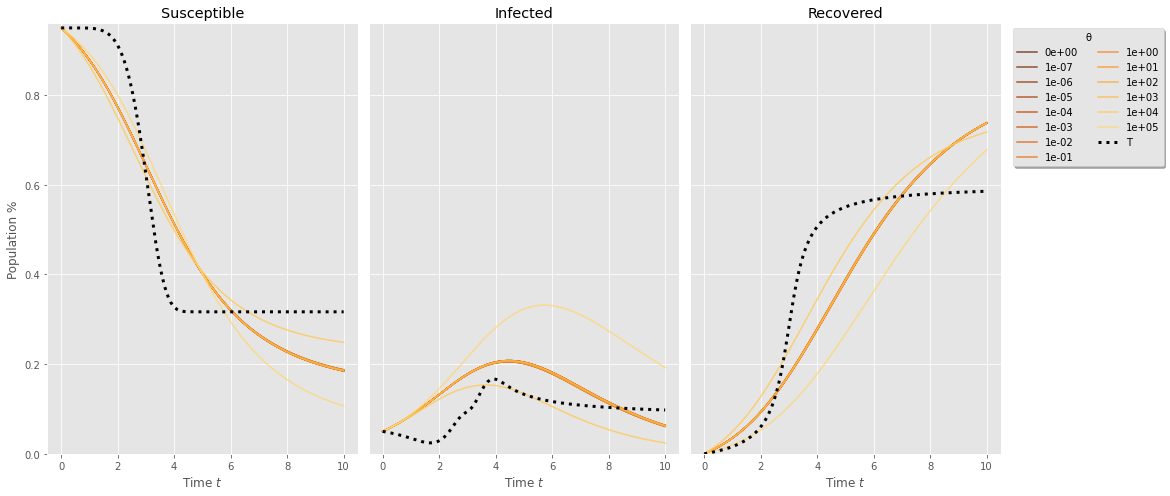

In [36]:
# Multiplot
fig, ax = plt.subplots(1, 3, figsize=(16, 7))
ax[1].set_yticklabels([]);
ax[2].set_yticklabels([]);
for tick in ax[1].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
for tick in ax[2].yaxis.get_major_ticks():
    tick.tick1line.set_visible(False)
    '''tick.tick2line.set_visible(False)
    tick.label1.set_visible(False)
    tick.label2.set_visible(False)'''

k = colours_GD.shape[0] - 1
for θ, ρ in States.items():
    
    # Susceptible
    ax[0].plot(Tₑ, ρ[0]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Infected
    ax[1].plot(Tₑ, ρ[1]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    # Recovered
    ax[2].plot(Tₑ, ρ[2]/n, color = colours_GD[k], alpha = 0.8, label = '{0:.0e}'.format(θ))
    
    k -= 1
    
# Add target
ax[0].plot(Tₑ, ρ̂[0]/n, ':', c='black', linewidth=3, label = 'T')
ax[1].plot(Tₑ, ρ̂[1]/n, ':', c='black', linewidth=3, label = 'T')
ax[2].plot(Tₑ, ρ̂[2]/n, ':', c='black', linewidth=3, label = 'T')

ax[0].set_ylim([0.0, (Sₒ+2)/n]);    ax[0].set_xlabel(r'Time $t$');    ax[0].set_title(r'Susceptible')
ax[1].set_ylim([0.0, (Sₒ+2)/n]);    ax[1].set_xlabel(r'Time $t$');    ax[1].set_title(r'Infected')
ax[2].set_ylim([0.0, (Sₒ+2)/n]);    ax[2].set_xlabel(r'Time $t$');    ax[2].set_title(r'Recovered')

ax[0].set_ylabel('Population %')

plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, title='θ')
fig.tight_layout()
plt.savefig('Outputs/Regularisation – States – PGD.pdf', bbox_inches='tight', pad_inches=0)

[]

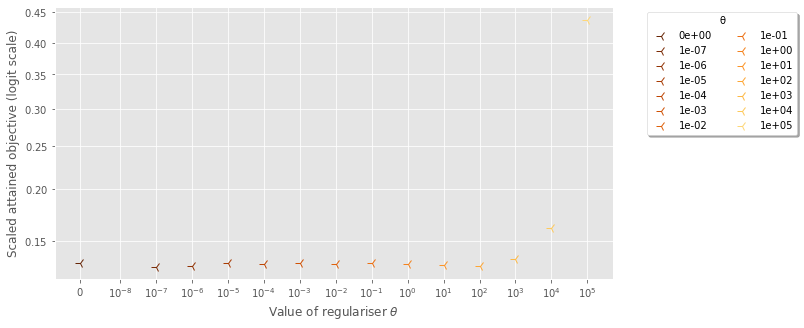

In [37]:
# Plot objective against θ
plt.figure(figsize=(10,5))

k = colours_GD.shape[0] - 1
for θ, fᵥ in Stats['obj'].iteritems():
    
    # Susceptible
    plt.plot(θ, fᵥ, color = colours_GD[k], #markeredgecolor = "xkcd:robin's egg blue",
             alpha=1, marker='3', linestyle = '', markersize=10, 
             label = '{0:.0e}'.format(θ))
    
    k -= 1
    
    
plt.xscale('symlog', linthresh = 1e-8)
plt.yscale('logit')
plt.legend(bbox_to_anchor=(1.34, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')

plt.xlabel(r'Value of regulariser $\theta$');    plt.ylabel('Scaled attained objective (logit scale)')
plt.plot()

Compute finer mesh:

In [38]:
θ = 0.0

In [39]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.0,1.0,nβ)
γ_axis = linspace(0.02,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a(asarray([β,γ])).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [40]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.09590670201662092; (β,γ): 0.006666666666666667 0.706


Plot of objective evaluations for f(α)/n² over finer grid


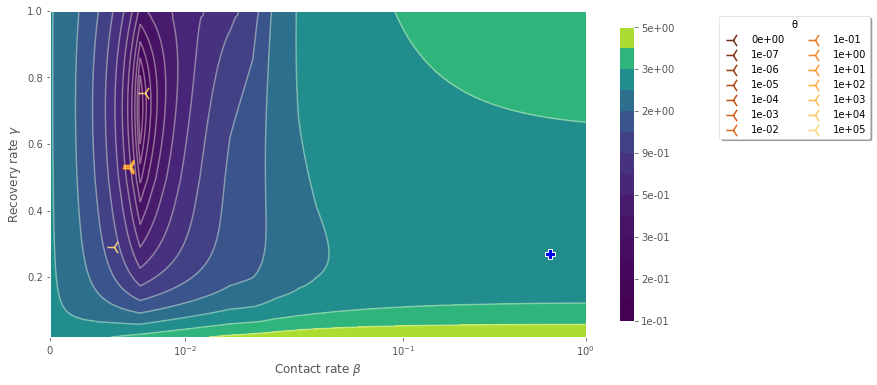

In [41]:
# Contour plot
print('Plot of objective evaluations for f(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = np.logspace( np.log( Misfit.min() ), np.log( Misfit.max() ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')


# Starting point
plt.plot( rng(0).uniform(0,1,2)[0], rng(0).uniform(0,1,2)[1], 
         markersize=10, marker='P', color='white', markerfacecolor='b' )

# Approximate minimisers
k_row = colours_GD.shape[0] - 1
for row in Stats.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 200, label = '{0:.0e}'.format(θ))

    k_row -= 1
    
#plt.legend(handles=scatter.legend_elements()[0] )#, labels=Stats['β'].index.values)



'''
# Optimisation path PGD
ℓ_PGD = 1660
plt.plot( β_PGD[:-ℓ_PGD], γ_PGD[:-ℓ_PGD], c='xkcd:pale gold', markeredgecolor = 'gold',
         alpha=1, marker='3', linestyle = ':', markersize='10', label='PGD')
plt.plot( β_PGD[ ℓ_PGD:], γ_PGD[ ℓ_PGD:], c='gold', alpha=0.01, marker='3', linestyle = ':', markersize='4')

# Optimisation path FISTA
ℓ_FISTA = 20
plt.plot( β_FISTA[:ℓ_FISTA], γ_FISTA[:ℓ_FISTA], c='r', 
         markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa',
         alpha=0.5, marker='.', linestyle = '-', markersize='7', label='FISTA')
plt.plot( β_FISTA[ ℓ_FISTA-1:], γ_FISTA[ ℓ_FISTA-1:], c='r', markeredgecolor = 'xkcd:rosa',
         alpha=0.5, marker='.',linestyle = '-',markersize='1')


# Optimisation path LM
plt.plot( β_LM, γ_LM, c='xkcd:turquoise blue', 
         markeredgecolor = "xkcd:robin's egg blue", markerfacecolor = '#FFD300', 
         alpha=0.5, marker='d', linestyle = '-.', markersize=4, label='LM-BFGS')


# Best estimated minimiser
plt.plot( α̂_LM[0], α̂_LM[1], markersize=15, marker='*', color='white' )
'''


ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[a].pdf', bbox_inches='tight', pad_inches=0)

Compute finer mesh around minimisers:

In [42]:
θ = 0.0

In [43]:
# Finer evaluations
nβ, nγ = 151, 151
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.0,0.01,nβ)
γ_axis = linspace(0.02,1.0,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a(asarray([β,γ])).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [44]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.08483374432970263; (β,γ): 0.0078000000000000005 0.8954666666666666


In [45]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.08483374432970263; (β,γ): 0.0078000000000000005 0.8954666666666666


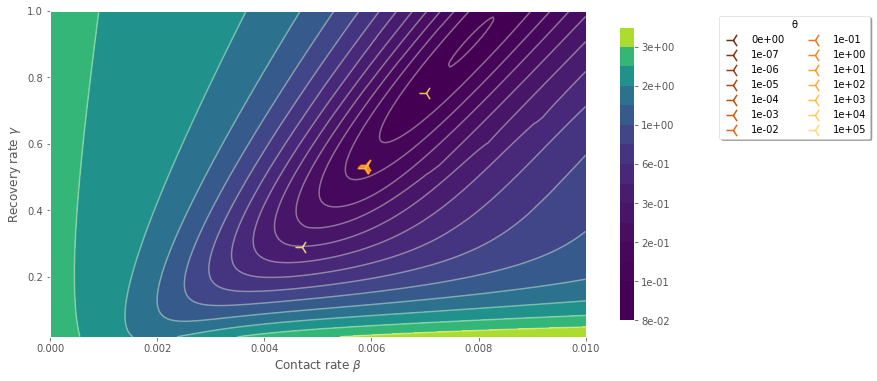

In [46]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit).min(),(Misfit).max(),15)
ℓ = append( 0.086, np.logspace( np.log( Misfit[Misfit>0.0].min() ), np.log( Misfit.max() ), 
                num=15, endpoint=True, base=np.e) )
ℓ.sort()

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
cp = ax.contourf(X_c, Y_c, Misfit, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min


# Approximate minimisers
k_row = colours_GD.shape[0] - 1
for row in Stats.iterrows():
    θ = row[0]
    
    scatter = plt.scatter(row[1]['β'], row[1]['γ'], color = colours_GD[k_row],
         alpha = 0.95, marker='3', s = 200, label = '{0:.0e}'.format(θ))

    k_row -= 1
    
#plt.legend(handles=scatter.legend_elements()[0] )#, labels=Stats['β'].index.values)

'''# Optimisation path PGD
ℓ_PGD = 21
h_PGD = 33
plt.plot( clip(β_PGD[ ℓ_PGD:h_PGD],0.02,0.032), clip(γ_PGD[ ℓ_PGD:h_PGD],0.5, 0.7), 
            c='xkcd:pale gold', markeredgecolor = 'gold', linewidth=2.3,
                 alpha=1, marker='3', linestyle = ':', markersize='10', label='PGD')
plt.plot( β_PGD[ h_PGD-1:], γ_PGD[ h_PGD-1:], c='gold', alpha=0.7, marker='3', linestyle = '-', 
         markersize=0.1, linewidth=0.05)


# Optimisation path FISTA
ℓ_FISTA = 30
h_FISTA = 40
plt.plot( β_FISTA[ℓ_FISTA:h_FISTA], γ_FISTA[ℓ_FISTA:h_FISTA], c='r', 
             markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa', linewidth=3,
                 alpha=0.75, marker='.', linestyle = '-', markersize='3', label='FISTA')
plt.plot( β_FISTA[ h_FISTA:], γ_FISTA[ h_FISTA:], c='r', markeredgecolor = 'xkcd:rosa', linewidth=2,
             alpha=0.5, marker='.',linestyle = '-',markersize='1')


# Optimisation path LM
ℓ_LM = 18
plt.plot( clip(β_LM[ℓ_LM:],0.02,0.032), clip(γ_LM[ℓ_LM:],0.5, 0.7), c='xkcd:turquoise blue', 
             markeredgecolor = "xkcd:robin's egg blue", markerfacecolor = '#FFD300', linewidth=2.3,
                 alpha=0.9, marker='d', linestyle = '-.', markersize=5, label='LM-BFGS')


# Best estimated minimiser
plt.plot( α̂_LM[0], α̂_LM[1], markersize=15, marker='*', color='white' )'''





fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
#plt.xscale('symlog', linthresh = 1.5e-2)
plt.legend(bbox_to_anchor=(1.54, 1), loc="upper right", shadow=True, ncol=2, facecolor='w', title='θ')
plt.show()
#fig.savefig('Outputs/Regularisation – Contour[b].pdf', bbox_inches='tight', pad_inches=0)

---

In [47]:
Stats

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
0.000000e+00,78,0.132124,2.601850,0.005874,0.528139,1.480791,-0.359333,0.920062,1.077465,1.480791,0.359333
1.000000e-07,78,0.129332,2.581747,0.005914,0.536430,1.528241,-0.341562,0.934902,1.107291,1.528241,0.341562
1.000000e-06,72,0.129795,2.539128,0.005901,0.535036,0.269349,-0.338157,0.303753,0.305695,0.338157,0.269349
1.000000e-05,74,0.132180,2.523111,0.005870,0.527980,0.867274,-0.357242,0.612258,0.663245,0.867274,0.357242
1.000000e-04,75,0.131076,2.504316,0.005889,0.531202,1.607987,-0.353338,0.980663,1.164146,1.607987,0.353338
1.000000e-03,81,0.131830,2.569741,0.005878,0.528992,1.589524,-0.358800,0.974162,1.152242,1.589524,0.358800
1.000000e-02,78,0.131634,2.541207,0.005875,0.529574,0.422374,-0.350922,0.386648,0.388295,0.422374,0.350922
1.000000e-01,74,0.132409,2.512869,0.005864,0.527330,0.358794,-0.356347,0.357571,0.357573,0.358794,0.356347
1.000000e+00,73,0.131288,2.489465,0.005885,0.530589,1.485600,-0.353625,0.919613,1.079828,1.485600,0.353625
1.000000e+01,71,0.130579,2.464540,0.005895,0.532781,1.327501,-0.347368,0.837435,0.970290,1.327501,0.347368


In [48]:
Stats.to_pickle('Outputs/Regularisation – PGD - Final.pkl') # To read back use pd.read_pickle(file_name)

---

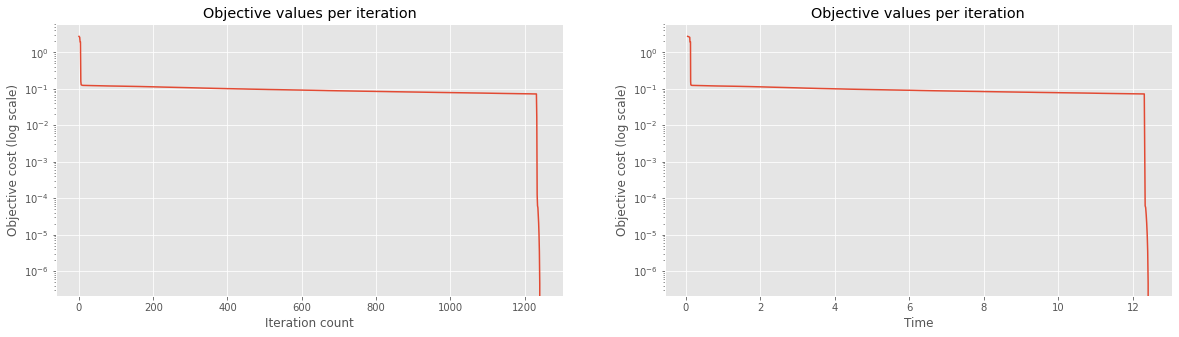

In [49]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['obj'] - min(every_iter['obj']))
plt.yscale('log');    
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']) )
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [50]:
df_critical = pd.DataFrame.from_dict(every_critical)
#df_critical.to_pickle(out_folder+'Critical.pkl') # To read back use pd.read_pickle(file_name)
#df_critical.to_excel(out_folder+'Critical.xlsx')
#display(df_critical)

# If we want this table in LaTeX format run:
#print(df_critical.to_latex(index=False))

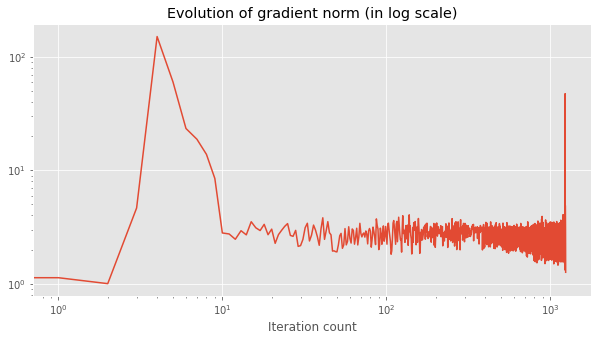

In [51]:
# Evolution of gradient norm
plt.figure(figsize=(10,5))
plt.plot(df_every['norms-ℓ_2'].to_numpy())
#plt.plot(df_every['norms-ℓ_1'].to_numpy())
#plt.plot(df_every['norms-max'].to_numpy())
plt.yscale('log')
plt.xscale('log')
plt.title('Evolution of gradient norm (in log scale)')
plt.xlabel('Iteration count')
plt.show()

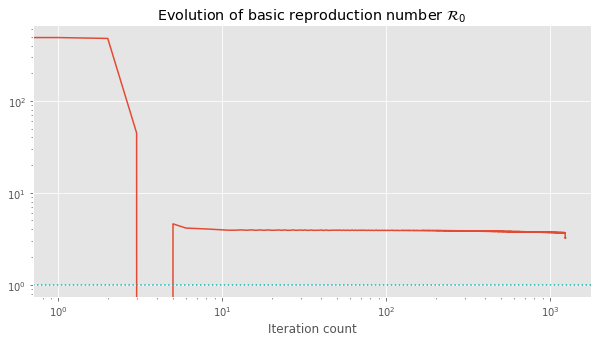

In [52]:
# Evolution of basic reproduction number
plt.figure(figsize=(10,5))
plt.plot(df_every['β'].to_numpy() * n / df_every['γ'].to_numpy())
plt.axhline(y=1, c='c', linestyle=':')
plt.yscale('log')
plt.xscale('log')
plt.title('Evolution of basic reproduction number $\mathcal{R}_0$')
plt.xlabel('Iteration count')
plt.show()

---